In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import skvideo.io
import io
import base64
from IPython.display import HTML

sns.set()
plt.rcParams["figure.figsize"] = fig_size = (12, 8)
plt.rcParams["axes.titlesize"] = 'x-large'

In [2]:
# make data
x = np.array(range(-10,10))*np.pi/2
y = 5*np.sin(x/5)
eps_homo = np.random.normal(y)
eps_hetero = np.random.normal(y) * np.abs(y)
y_homo = y + eps_homo
y_hetero = y + eps_hetero

In [3]:
x_miss = np.concatenate((x[:13],x[18:]))
y_homo_miss = np.concatenate((y_homo[:13],y_homo[18:]))

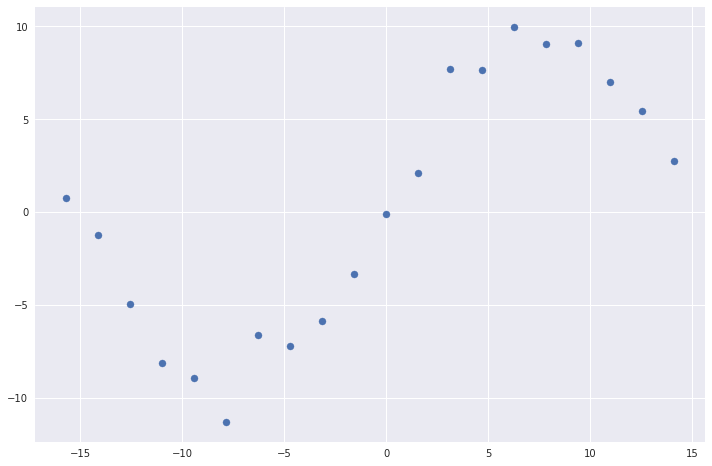

In [4]:
# Homoscedastic aleatoric error
plt.scatter(x,y_homo, s=50)
plt.show()

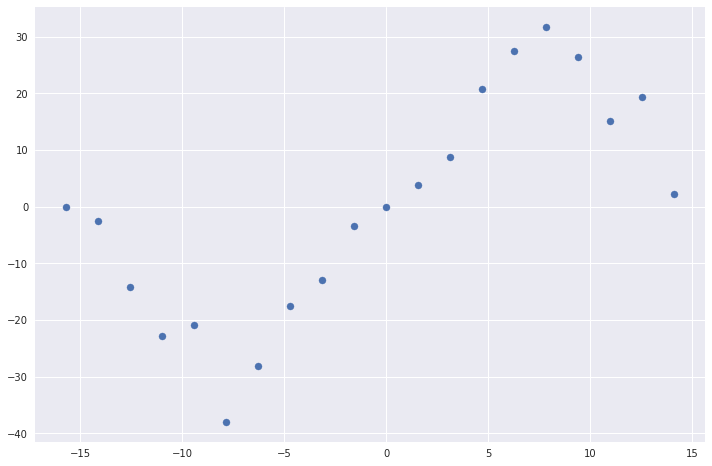

In [5]:
# Heteroscedastic aleatoric error
plt.scatter(x,y_hetero, s=50)
plt.show()

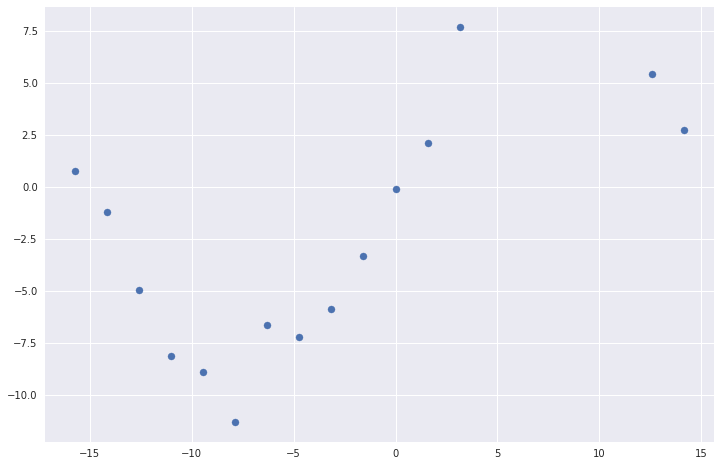

In [6]:
# Homoscedastic aleatoric error
plt.scatter(x_miss,y_homo_miss, s=50)
plt.show()

In [7]:
class Gaussian(object):
    def __init__(self, mu, log_var):
        super().__init__()
        self.mu = mu
        self.log_var = log_var
        self.normal = torch.distributions.normal.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.sqrt(torch.exp(self.log_var))
    
    def sample(self):
        epsilon = self.normal.sample(self.log_var.size())
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (- torch.log(2 * 3.14 * self.sigma ** 2)/2
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [8]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_log_var = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-10,-9))
        self.weight = Gaussian(self.weight_mu, self.weight_log_var)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_log_var = nn.Parameter(torch.Tensor(out_features).uniform_(-10,-9))
        self.bias = Gaussian(self.bias_mu, self.bias_log_var)

        self.log_prior = 0.
        self.log_variational_posterior = 0.

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = -(weight**2 + bias**2).sum()/2
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [9]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(1, 20)
        self.l2 = BayesianLinear(20, 20)
        self.out = BayesianLinear(20, 1)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 1)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = self.out(x, sample)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
    + self.l2.log_prior \
    + self.out.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
    + self.l2.log_variational_posterior \
    + self.out.log_variational_posterior
    
    def sample_elbo(self, input, target):
        output = self(input, sample=True)
        log_prior = self.log_prior()
        log_variational_posterior = self.log_variational_posterior()
        negative_log_likelihood = F.mse_loss(output, target, size_average=False)/0.1
        loss = (log_variational_posterior - log_prior) + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

In [10]:
video_path = './result_BBVI.mp4'
writer = skvideo.io.FFmpegWriter(video_path)

net = BayesianNetwork()
optimizer = torch.optim.Adam(net.parameters())
    
for _ in range(10**5):
    # Sample the data with replacement
    index = np.random.choice(range(len(x_miss)),size = 10)
    x_chosen = Variable(torch.FloatTensor(x_miss[index]))
    y_chosen = Variable(torch.FloatTensor(y_homo_miss[index]).view(-1,1))
    
    # Prdict and calculate the loss
    net.zero_grad()
    loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(x_chosen, y_chosen)
    loss.backward()
    optimizer.step()
    
    if (_%10**2) == 0:
        x_test = np.array(range(-40,40))/2.*np.pi
        x_chosen = Variable(torch.FloatTensor(x_test).view(-1,1))
        y_pred = np.zeros((100, 80,1))
        y_uncert = np.zeros((100, 80,1))

        for i in range(100):
            y_predict= net.forward(x_chosen)
            y_pred[i] = y_predict.cpu().data

        y_pred_mean = y_pred.mean(axis = 0)
        y_pred_std = y_pred.std(axis = 0)
        
        # make figure
        fig = plt.figure()
        plt.scatter(x_miss,y_homo_miss, s=50)
        plt.plot(x_test, y_pred_mean)
        plt.fill_between(x_test, y_pred_mean.reshape(-1) - y_pred_std.reshape(-1), 
                         y_pred_mean.reshape(-1) + y_pred_std.reshape(-1),color='gray', alpha=0.5)
        plt.fill_between(x_test, y_pred_mean.reshape(-1) - 2*y_pred_std.reshape(-1), 
                         y_pred_mean.reshape(-1) + 2*y_pred_std.reshape(-1),color='gray', alpha=0.3)
    
        plt.xlim(-60,60)
        plt.ylim(-20,20)
        plt.title(str(_)+' th loss :'+ str(negative_log_likelihood.cpu().item()*0.1))
        fig.canvas.draw()

        # Get the RGBA buffer from the figure
        w,h = fig.canvas.get_width_height()
        buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
        buf.shape = (h, w, 4)
        plot = buf[:, :, 1:]
        plt.close()
        outputframe = np.zeros((h, w, 3))
        outputframe[:, :] = plot
        writer.writeFrame(outputframe)

writer.close()

video = io.open('./result_BBVI.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

/home/sungyub/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
